# Project for the Biomedical Data Science Summer School

## Group 4: Protein-Protein Interaction Network

- Yulia Zaikina
- Katalin Maricza
- Karen Torres
- Levente Tyukodi
- Balázs István Formanek

In this Jupyter Notebook, we detail every programming concept we used to extract and process data in our Network Science project.

Complementary visualisation processes were performed using Cytoscape software.

## Problem framing:

Large-scale protein-protein interaction (PPI) networks offer insights into complex biological processes and disease mechanisms. By mapping disease or behavior phenotypes onto these networks, we can enhance predictions of relevant signaling pathways and identify new therapeutic targets. Integrating protein expression data focusing on specific brain regions and synaptic proteins will help prioritize relevant pathways for disease treatment.

**This analysis will be focused on the PPI Network pathways for Brain-associated diseases with the purpose of identifying key expression players and their functional relationship with the diseases.**

### Objectives
- Analyze PPI networks related to brain diseases to identify proteins and possible signaling pathways.
- Identify co-expression patterns in brain regions associated with disease for potential therapeutic targets.

### Data Preparation
Our original study database contains the PPI network for 519 disease pathways. It was initially created to analyze higher-order network structures via network subgraphs.

### Database: Human protein-protein interaction network
Available here: https://snap.stanford.edu/biodata/datasets/10000/10000-PP-Pathways.html

This is protein-protein interaction network that contains physical interactions between proteins that are experimentally documented in humans, such as metabolic enzyme-coupled interactions and signaling interactions. Nodes represent human proteins and edges represent physical interaction between proteins in a human cell. The information is restricted to protein-protein interactions that are experimentally verified in wet biological laboratories.

#### Nodes association

In the PPI network, each row represents an edge connecting two nodes, where the nodes are proteins identified by their corresponding Entrez IDs. To assign protein properties to these nodes, we utilized the [MyGene.info](https://mygene.info/) gene query web service, which is implemented in Python using the *mygene* library.

Queried properties: name, symbol.

### Supplementary database: bio-pathways-associations: Disease Pathways in the Human Interactome

Our PPI Network was associated with the corresponding associated diseases by using an additional database available at https://snap.stanford.edu/pathways/

## Methodology

We built a series of PPI network subgraphs using NetworkX and Cytoscape focusing on brain disease-related proteins to gather interconnection between brain diseases and their corresponding protein interaction.

## Conclusion
Our  objective was to identify proteins that play a pivotal role across multiple brain disease groups. After preparing and organizing the data, we hypothesized that such proteins may underlie common mechanisms contributing to disease pathophysiology. Based on our network analysis and disease group classification, we observed several overlaps between groups. Notably, we identified four proteins — BDNF, ABCB1, SOD2, and GSTP1 — that are present across all groups, suggesting their potential involvement in shared pathological pathways.

## References
* *Large-scale analysis of disease pathways in the human interactome.
Monica Agrawal, Marinka Zitnik, and Jure Leskovec. Pacific Symposium on Biocomputing. 2018. (http://psb.stanford.edu/psb-online/proceedings/psb18/agrawal.pdf)*
* *OpenAI. (2025, August). ChatGPT (August 2025 version) [Large language model]. https://chat.openai.com*
* *High throughput protein expression screening in the nervous system – needs and limitations.  
Chris N. G. Anderson and Seth G. N. Grant. The Journal of Physiology*. 2006.  
(https://doi.org/10.1113/jphysiol.2006.113795)




## Importing libraries


In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

%pip install mygene
import mygene

import tarfile
from collections import defaultdict

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 3.9 MB/s eta 0:00:00


## Data loading and description

Load **PP-Pathways** and **bio-pathways-associations** data from SNAP \\
*Note: network data files are compressed and should be uncompressed correctly.*

In [ ]:
!wget https://snap.stanford.edu/biodata/datasets/10000/files/PP-Pathways_ppi.csv.gz -O PP-Pathways_ppi.csv.gz
!wget https://snap.stanford.edu/pathways/bio-pathways-associations.tar.gz -O bio-pathways-associations.tar.gz

--2025-08-05 07:43:20--  https://snap.stanford.edu/biodata/datasets/10000/files/PP-Pathways_ppi.csv.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1683213 (1.6M) [application/x-gzip]
Saving to: ‘PP-Pathways_ppi.csv.gz’

PP-Pathways_ppi.csv 100%[===================>]   1.60M  1.19MB/s    in 1.3s    

2025-08-05 07:43:21 (1.19 MB/s) - ‘PP-Pathways_ppi.csv.gz’ saved [1683213/1683213]

--2025-08-05 07:43:21--  https://snap.stanford.edu/pathways/bio-pathways-associations.tar.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60146 (59K) [application/x-gzip]
Saving to: ‘bio-pathways-associations.tar.gz’

bio-pathways-associ 100%[===================>]  58.74K   287KB/s    in 0.2s    


Load csv data to a DataFrame. \\
Every row in the file contains of two number separated with a coma. This is a representation of the edge list of the network, where the numbers are protein Entrez IDs.

In [ ]:
pp_csv_file = pd.read_csv('PP-Pathways_ppi.csv.gz', compression='gzip', header=None, names=['node1', 'node2'])

As the csv file only contains the edges of the network, it can be directly added to a networkx (nx) network.

In [ ]:
# Creating a graph
G = nx.from_pandas_edgelist(pp_csv_file, "node1", "node2")

print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Some nodes: {list(G.nodes)[:5]}")
print(f"Number of edges: {G.number_of_edges()}")
print(f"Some edges: {list(G.edges)[:5]}")


Number of nodes: 21557
Some nodes: [1394, 2778, 6331, 17999, 122704]
Number of edges: 342353
Some edges: [(1394, 2778), (1394, 808), (1394, 801), (1394, 7349), (1394, 2770)]


Although we successfully created the network with nodes and edges, the nodes are not descriptive at all, as their names are numerical id values. \\
Hence we create a function to get protein *name* and *symbol* properties based on Entrez ID using *mygene* library (https://pypi.org/project/mygene/) from all available properties.

In [ ]:
def get_data_from_entrez_id(id_list, fields = "symbol, name"):
  # Get protein data from entrez id list
  # Define requred fields with fields value. Possible field values can be found here: https://docs.mygene.info/en/latest/doc/query_service.html#available_fields
  mg = mygene.MyGeneInfo()

  result = mg.querymany(id_list, scopes='entrezgene', fields=fields, species='human')
  return result

1. We tested function for two ids:

*Note: query may return without success, which should be handeled correctly.*

2. We used this function get data for all nodes and create database

In [ ]:
test_id = [1394, 20947]
meta = get_data_from_entrez_id(test_id)[0]

#if "notfound" in list(meta.keys()):
#  print("Unsuccessfull test query")
#else:
#  print("Protein metadata query example with id: ", test_id, " : \n symbol:" , meta["symbol"], "name:  ", meta["name"] )

meta = get_data_from_entrez_id(list(G.nodes))

INFO:biothings.client:querying 1-2 ...
INFO:biothings.client:Finished.
INFO:biothings.client:Pass "returnall=True" to return complete lists of duplicate or missing query terms.
INFO:biothings.client:querying 1-1000 ...
INFO:biothings.client:querying 1001-2000 ...
INFO:biothings.client:querying 2001-3000 ...
INFO:biothings.client:querying 3001-4000 ...
INFO:biothings.client:querying 4001-5000 ...
INFO:biothings.client:querying 5001-6000 ...
INFO:biothings.client:querying 6001-7000 ...
INFO:biothings.client:querying 7001-8000 ...
INFO:biothings.client:querying 8001-9000 ...
INFO:biothings.client:querying 9001-10000 ...
INFO:biothings.client:querying 10001-11000 ...
INFO:biothings.client:querying 11001-12000 ...
INFO:biothings.client:querying 12001-13000 ...
INFO:biothings.client:querying 13001-14000 ...
INFO:biothings.client:querying 14001-15000 ...
INFO:biothings.client:querying 15001-16000 ...
INFO:biothings.client:querying 16001-17000 ...
INFO:biothings.client:querying 17001-18000 ...

3. We added metadata to the network nodes in order to connect the nodes with their respective identification for the procession of the database

With this we connect the nodes and edges to their corresponding gene annotations:


In [ ]:
list_of_unassigned_nodes = []
for n in G.nodes:
  m = meta[list(G.nodes).index(n)]  # Get metadata for the current node

  if "notfound" in list(m.keys()):
    list_of_unassigned_nodes.append(n)
    continue

  G.nodes[n]["symbol"] = m["symbol"]
  G.nodes[n]["name"] = m["name"]

print(f"Number of unassigned nodes: {len(list_of_unassigned_nodes)}")

Number of unassigned nodes: 4236


4. We check the first few nodes to see if the assocation is properly setup

In [ ]:
for n in list(G.nodes)[:10]:
  print(n, ":", G.nodes[n])

1394 : {'symbol': 'CRHR1', 'name': 'corticotropin releasing hormone receptor 1'}
2778 : {'symbol': 'GNAS', 'name': 'GNAS complex locus'}
6331 : {'symbol': 'SCN5A', 'name': 'sodium voltage-gated channel alpha subunit 5'}
17999 : {}
122704 : {'symbol': 'MRPL52', 'name': 'mitochondrial ribosomal protein L52'}
54460 : {'symbol': 'MRPS21', 'name': 'mitochondrial ribosomal protein S21'}
2597 : {'symbol': 'GAPDH', 'name': 'glyceraldehyde-3-phosphate dehydrogenase'}
2911 : {'symbol': 'GRM1', 'name': 'glutamate metabotropic receptor 1'}
4790 : {'symbol': 'NFKB1', 'name': 'nuclear factor kappa B subunit 1'}
79155 : {'symbol': 'TNIP2', 'name': 'TNFAIP3 interacting protein 2'}


Save network with additional data

In [ ]:
nx.write_gml(G, "PP-Pathways_ppi_with_data.gml")

## Brain Diseases - Network Analysis

In order to evaluate the proteins that have comunal interactive proteins we created a new Network with the relationships

### Connectivity

We evaluated the connection between nodes, how many of them are connected within the network, for this the following questions were raised:

- Is the complete network connected?

In [ ]:
nx.is_connected(G)

False

- How many components are there?

In [ ]:
components = list(nx.connected_components(G))

print(f"Number of connected components: {len(components)}")
for i, component in enumerate(components):
    print(f"Component {i + 1}: {component}")

Number of connected components: 26
Component 1: {1, 2, 131076, 9, 10, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 43, 131118, 47, 48, 49, 50, 51, 52, 53, 54, 55, 58, 59, 60, 70, 71, 72, 81, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 393313, 97, 98, 100, 101, 102, 103, 104, 105, 131177, 107, 108, 109, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 123, 124, 125, 126, 127, 128, 130, 131, 132, 133, 134, 135, 136, 140, 141, 142, 143, 146, 147, 148, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 172, 174, 175, 176, 177, 178, 181, 182, 183, 185, 186, 187, 189, 190, 191, 196, 197, 199, 202, 203, 204, 205, 207, 208, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 229, 230, 231, 238, 239, 240, 241, 242, 246, 247, 248, 249, 250, 251, 258, 259, 262, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 283, 284, 285, 286, 287, 288, 290,

It is visible that there is one component with large number of nodes an the other components contains only a few nodes. Let us see how many nodes and edges are in this giant subgrph

In [ ]:
#Comparing the total nodes and edges with the giant component's nodes and edges
largest_cc = max(nx.connected_components(G), key=len)
G_giant = G.subgraph(largest_cc)

print(f"Nodes in giant component: {G_giant.number_of_nodes()} (compared to {G.number_of_nodes()})")
print(f"Edges in giant component: {G_giant.number_of_edges()} (compared to {G.number_of_edges()})")

Nodes in giant component: 21521 (compared to 21557)
Edges in giant component: 342316 (compared to 342353)


Almost every protein is connected to each other, except for 36 (21557-21521=36)

###  Degree Distribution

The degree of a node represents the number of connections the network has. Analyzing the degree distribution helps understand how connected nodes are across the network.

Degree Centrality: Measures the number of connections a node has. Nodes with higher degrees are often considered more important in terms of connectivity.



In [ ]:
degree = nx.degree(G)
print("Degrees: ", degree)

degree_cent = nx.degree_centrality(G)
print("Degree Centrality: ", degree_cent)

Degrees:  [(1394, 12), (2778, 98), (6331, 33), (17999, 10), (122704, 93), (54460, 101), (2597, 304), (2911, 27), (4790, 277), (79155, 29), (6146, 266), (101929876, 66), (109, 33), (27115, 21), (1390, 49), (84528, 100), (324, 301), (10982, 39), (26268, 15), (6500, 251), (3609, 463), (3954, 14), (152485, 17), (57504, 63), (1537, 146), (55967, 86), (8452, 1228), (7278, 76), (23392, 137), (5687, 175), (72462, 44), (5573, 123), (2355, 66), (29922, 114), (154796, 133), (7408, 97), (26039, 60), (6597, 269), (5347, 268), (3297, 116), (375056, 36), (64419, 6), (155871, 312), (170575, 5), (57154, 390), (3309, 517), (5501, 308), (3189, 100), (57162, 34), (7321, 278), (6498, 116), (7329, 502), (84281, 9), (4654, 114), (5879, 269), (23568, 12), (4193, 470), (24149, 22), (6631, 247), (9775, 451), (8570, 99), (9757, 51), (155908, 222), (5034, 148), (8559, 211), (56850, 69), (84445, 267), (253461, 52), (221, 77), (84735, 32), (261726, 42), (5537, 61), (554223, 19), (79699, 20), (9869, 161), (121504, 1

Which proteins have the larges numbers of connections?

In [ ]:
sorted_degree = sorted(degree, key=lambda x: x[1], reverse=True)

top_10 = sorted_degree[:10]

print("\nTop 10 nodes by degree:")
for node, deg in top_10:
    node_info = G.nodes[node]
    print(f"Node ID: {node}, Degree: {deg}, Symbol: {node_info.get('symbol', 'N/A')}, Name: {node_info.get('name', 'N/A')}")


Top 10 nodes by degree:
Node ID: 351, Degree: 2132, Symbol: APP, Name: amyloid beta precursor protein
Node ID: 4914, Degree: 1965, Symbol: NTRK1, Name: neurotrophic receptor tyrosine kinase 1
Node ID: 1994, Degree: 1866, Symbol: ELAVL1, Name: ELAV like RNA binding protein 1
Node ID: 7316, Degree: 1647, Symbol: UBC, Name: ubiquitin C
Node ID: 7514, Degree: 1256, Symbol: XPO1, Name: exportin 1
Node ID: 8452, Degree: 1228, Symbol: CUL3, Name: cullin 3
Node ID: 4343, Degree: 1178, Symbol: MOV10, Name: Mov10 RNA helicase
Node ID: 10482, Degree: 1153, Symbol: NXF1, Name: nuclear RNA export factor 1
Node ID: 2885, Degree: 1081, Symbol: GRB2, Name: growth factor receptor bound protein 2
Node ID: 7157, Degree: 1001, Symbol: TP53, Name: tumor protein p53


These top 10 nodes, with their high degrees, are likely hubs in the PPI network, meaning they interact with many other proteins and are critical to maintaining cellular homeostasis and regulating essential pathways.

- Many of these proteins, such as APP, NTRK1, and TP53, are known to be involved in significant diseases (e.g., Alzheimer's, neurodegenerative disorders, cancer). Their high connectivity suggests that targeting these proteins or their interaction partners might have therapeutic potential.

- The ubiquitin-proteasome system (e.g., UBC, CUL3) and RNA regulation mechanisms (e.g., MOV10, NXF1) also feature prominently in these hubs, highlighting the importance of protein degradation and RNA processing in disease mechanisms.


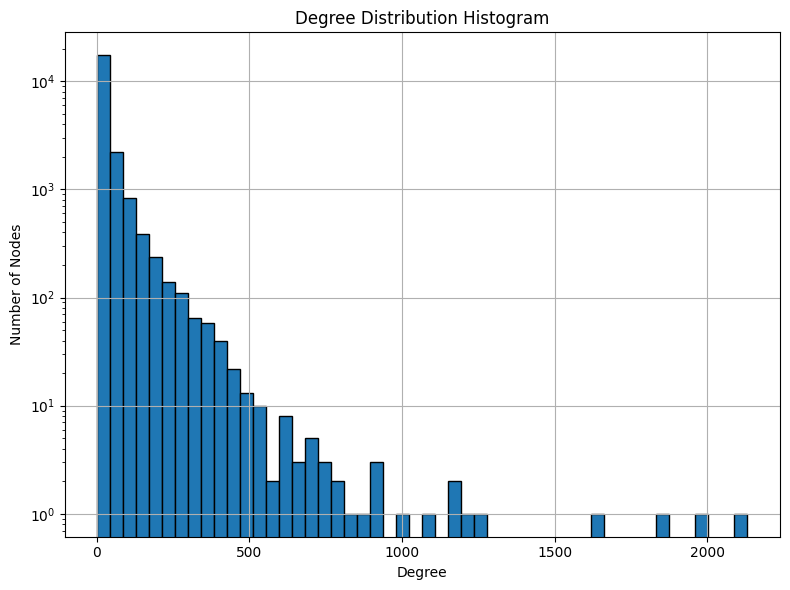

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist([d for _, d in degree], bins=50, edgecolor='black')
plt.title("Degree Distribution Histogram")
plt.xlabel("Degree")
plt.ylabel("Number of Nodes")
plt.yscale('log')
# plt.xscale('log')
plt.grid(True)
plt.tight_layout()
plt.savefig("degree_distr_main.png", dpi=300)
plt.show()

## Smallworldness Analysis

### Scale-Free Network

- The long tail and straight line trend on the log scale suggest a power-law distribution.

- This is characteristic of scale-free networks, which are common in biological systems.

- A few hub proteins dominate the connectivity.



### Betweenness

In [ ]:
# betweenness = nx.betweenness_centrality(G)
# print("Betweenness: ", betweenness)

In [ ]:
# sorted_betweenness = sorted(betweenness, key=lambda x: x[1], reverse=True)

# top_10 = sorted_betweenness[:10]

# print("\nTop 10 nodes by betweenness:")
# for node, deg in top_10:
#     node_info = G.nodes[node]
#     print(f"Node ID: {node}, betweenness: {deg}, Symbol: {node_info.get('symbol', 'N/A')}, Name: {node_info.get('name', 'N/A')}")

### Clustering Coefficient

We evaluated the clustering of the PPI network considering that:

- A high clustering coefficient could mean that those set of proteins are involved in the same biological process or pathway interact closely, forming functionality protein clusters.

- A low clustering coefficient could suggest that the network is more randomly structured or that proteins with unrelated functions are connected. Clustering will be low for those nodes with lower node connections, so we will be focusing in the top performers (Higher clustering nodes).

We calculated the top 10 nodes with the largest clustering_coefficient

In [ ]:
clustering_coefficient = nx.clustering(G)
print("Clustering Coefficient: ", clustering_coefficient)


Clustering Coefficient:  {1394: 0.045454545454545456, 2778: 0.04583333333333333, 6331: 0.03655913978494624, 17999: 0, 122704: 0.7533894343151005, 54460: 0.6463366336633664, 2597: 0.13753272755274912, 2911: 0.12, 4790: 0.08424684804246849, 79155: 0.20689655172413793, 6146: 0.3877174789722318, 101929876: 0.8587412587412587, 109: 0.01893939393939394, 27115: 0.01904761904761905, 1390: 0.08603145235892692, 84528: 0.08668209551861981, 324: 0.032861215236470565, 10982: 0.0960960960960961, 26268: 0.24761904761904763, 6500: 0.0652286565617308, 3609: 0.1767785849859284, 3954: 0.0989010989010989, 152485: 0.4117647058823529, 57504: 0.21300563236047107, 1537: 0.21561771561771562, 55967: 0.44623803009575924, 8452: 0.0415607417518394, 7278: 0.12912280701754386, 23392: 0.05635465865178188, 5687: 0.17182266009852218, 72462: 0.20084566596194503, 5573: 0.05137741046831956, 2355: 0.055944055944055944, 29922: 0.0687781400403664, 154796: 0.06059894304169113, 7408: 0.06405375139977604, 26039: 0.0719903206291

In [ ]:
# Find the top 10 nodes with the largest clustering_coefficient
top_10_clustering_coefficient_nodes = sorted(clustering_coefficient, key=clustering_coefficient.get, reverse=True)[:10]

print("Top 10 nodes by Clustering Coefficient:")
for node in top_10_clustering_coefficient_nodes:
    node_info = G.nodes[node]
    print(f"Node ID: {node}, Clustering Coefficient: {clustering_coefficient[node]:.4f}, Symbol: {node_info.get('symbol', 'N/A')}, Name: {node_info.get('name', 'N/A')}")

Top 10 nodes by Clustering Coefficient:
Node ID: 283933, Clustering Coefficient: 1.0000, Symbol: ZNF843, Name: zinc finger protein 843
Node ID: 1208, Clustering Coefficient: 1.0000, Symbol: CLPS, Name: colipase
Node ID: 93661, Clustering Coefficient: 1.0000, Symbol: CAPZA3, Name: capping actin protein of muscle Z-line subunit alpha 3
Node ID: 24812, Clustering Coefficient: 1.0000, Symbol: N/A, Name: N/A
Node ID: 259215, Clustering Coefficient: 1.0000, Symbol: LY6G6F, Name: lymphocyte antigen 6 family member G6F
Node ID: 498301, Clustering Coefficient: 1.0000, Symbol: N/A, Name: N/A
Node ID: 56917, Clustering Coefficient: 1.0000, Symbol: MEIS3, Name: Meis homeobox 3
Node ID: 57835, Clustering Coefficient: 1.0000, Symbol: SLC4A5, Name: solute carrier family 4 member 5
Node ID: 11787, Clustering Coefficient: 1.0000, Symbol: N/A, Name: N/A
Node ID: 140032, Clustering Coefficient: 1.0000, Symbol: RPS4Y2, Name: ribosomal protein S4 Y-linked 2


These top 10 nodes, with their high degrees, are likely hubs in the PPI network, meaning they interact with many other proteins and are critical to maintaining cellular homeostasis and regulating essential pathways.

- Many of these proteins, such as APP, NTRK1, and TP53, are known to be involved in significant diseases (e.g., Alzheimer's, neurodegenerative disorders, cancer). Their high connectivity suggests that targeting these proteins or their interaction partners might have therapeutic potential.

- The ubiquitin-proteasome system (e.g., UBC, CUL3) and RNA regulation mechanisms (e.g., MOV10, NXF1) also feature prominently in these hubs, highlighting the importance of protein degradation and RNA processing in disease mechanisms.

### Save network with centralities

- We saved the Network to further analysis in Cytoscape


In [ ]:
for node in G.nodes:
    G.nodes[node]["clustering"] = clustering_coefficient[node]
    # G.nodes[node]["betweenness"] = nx.betweenness_centrality(G)[node]
    G.nodes[node]["degree"] = degree[node]

nx.write_gml(G, "pp-network-G-with-centralities.gml")


## Brain Subgroup
### Filter network with brain related deseases

From the overall PPI Network we chose to filter the brain related diseases by categorizing them in the following groups according to diagnosis:

- **Addiction (A):**

Marijuana abuse, tobacco use disorder, tobacco addiction, susceptibility to (finding), amphetamine-related disorders, cocaine-related disorders, substance withdrawal syndrome, psychoses, substance-induced, substance-related disorders

- **Neurodegenerative (N):**

Neurodegenerative disorders, neurogenic inflammation, amyotrophic lateral sclerosis, amyotrophic lateral sclerosis 1, Parkinson disease, Parkinson disease, late-onset, Parkinsonian disorders

- **Psychiatric (P):**

Narcolepsy, bipolar disorder, schizophrenia, childhood, autistic disorder, attention deficit hyperactivity disorder, anxiety disorders, major depressive disorder, depressive disorder, panic disorder, mental disorders, cognition disorders, learning disorders, restless legs syndrome, memory disorders, catalepsy

- **Tumors (T):**

Brain neoplasms, neuroblastoma, glioblastoma, giant cell glioblastoma, glioma, gliosis, gliosarcoma, medulloblastoma, astrocytoma, neuroendocrine tumors

In [ ]:
disease_categories = {
    "addiction": [ "Marijuana Abuse", "Tobacco Use Disorder", "TOBACCO ADDICTION, SUSCEPTIBILITY TO (finding)", "Amphetamine-Related Disorders",
                  "Cocaine-Related Disorders", "Substance Withdrawal Syndrome", "Psychoses, Substance-Induced", "Substance-Related Disorders"
    ],
    "neurodegenerative": [ "Neurodegenerative Disorders", "Neurogenic Inflammation", "Amyotrophic Lateral Sclerosis", "AMYOTROPHIC LATERAL SCLEROSIS 1",
                          "Parkinson Disease", "PARKINSON DISEASE, LATE-ONSET", "Parkinsonian Disorders"
    ],
    "psychiatric": [ "Narcolepsy", "Bipolar Disorder", "Schizophrenia", "Schizophrenia, Childhood", "Autistic Disorder",
                    "Attention deficit hyperactivity disorder", "Anxiety Disorders", "Major Depressive Disorder", "Depressive disorder", "Panic Disorder",
                    "Mental disorders", "Cognition Disorders", "Learning Disorders", "Restless Legs Syndrome", "Memory Disorders", "Catalepsy"
    ],
    "tumors": [ "Brain Neoplasms", "Neuroblastoma", "Glioblastoma", "Giant Cell Glioblastoma", "Glioma", "Gliosis", "gliosarcoma", "Medulloblastoma",
               "Astrocytoma", "Neuroendocrine Tumors"
    ]
}

###  To associate the Proteins with Diseases
- Get bio-pathways-associations data.

*Note: csv data is compressed twice with 'tar' and 'gzip', so the uncompression is a little more complicated.*

In [ ]:
with tarfile.open('bio-pathways-associations.tar.gz', 'r:gz') as tar:
  # Show all files inside
  members = tar.getmembers()
  for member in members:
      print(member.name)
  # gz contains two files, from which we need the second ("./._bio-pathways-associations.csv", "bio-pathways-associations.csv")
  csv_member = members[1]

  if csv_member:
    f = tar.extractfile(csv_member)
    association_csv_file = pd.read_csv(f, encoding='latin1')

pd.set_option('display.max_columns', None)
print(association_csv_file)

./._bio-pathways-associations.csv
bio-pathways-associations.csv
    Disease ID                           Disease Name  \
0     C0036095               Salivary Gland Neoplasms   
1     C0033941           Psychoses, Substance-Induced   
2     C0043459                     Zellweger Syndrome   
3     C0033860                              Psoriasis   
4     C0027726                     Nephrotic Syndrome   
..         ...                                    ...   
514   C0005684  Malignant neoplasm of urinary bladder   
515   C0752347                      Lewy Body Disease   
516   C3160718          PARKINSON DISEASE, LATE-ONSET   
517   C0311375                      Arsenic Poisoning   
518   C0007621         Neoplastic Cell Transformation   

                                   Associated Gene IDs  
0    1462, 1612, 182, 2011, 2019, 2175, 2195, 23209...  
1    135, 1636, 207, 2099, 2912, 2950, 3350, 3362, ...  
2    3295, 5189, 5190, 5192, 5193, 5194, 5195, 5567...  
3    100271719, 10318, 

In [ ]:
# Make sure gene IDs are strings for matching
association_csv_file['Associated Gene IDs'] = association_csv_file['Associated Gene IDs'].astype(str).str.strip()
association_csv_file['Disease Name'] = association_csv_file['Disease Name'].str.strip()

disease_to_genes = defaultdict(set)

# Loop through each row and split gene IDs by comma
for _, row in association_csv_file.iterrows():
    disease = row['Disease Name'].strip()
    raw_genes = str(row['Associated Gene IDs']).split(',')

    # Clean and add each gene ID to the correct disease
    for gene in raw_genes:
        gene_id = gene.strip()
        if gene_id:
            disease_to_genes[disease].add(gene_id)

In [ ]:
print("Example disease-to-genes mapping:")
for disease in disease_categories["addiction"]:
    print(f"{disease}: {disease_to_genes.get(disease)}")


Example disease-to-genes mapping:
Marijuana Abuse: {'207', '1268', '2222', '816', '5243', '805', '801', '23780', '79571', '949'}
Tobacco Use Disorder: {'1138', '1548', '1139', '1813', '3936', '116068', '627', '57480', '196', '1136', '57521'}
TOBACCO ADDICTION, SUSCEPTIBILITY TO (finding): {'3094', '1138', '1137', '1548', '9568', '1555', '8973', '112398', '627', '1136', '6531', '1142'}
Amphetamine-Related Disorders: {'6622', '1012', '137868', '1814', '3359', '5592', '23362', '2353', '2272', '409', '5144', '340267', '2950', '5327', '6531', '81501', '23090', '1312', '43', '64757', '1812', '9463', '2952', '64754', '2052', '4988', '84196', '627', '79750', '5970', '23307', '3351', '3362', '1061', '22913', '344558', '26575', '4645', '2912', '4886', '5104', '1565', '1815', '54535', '5460', '1813', '5173', '1604', '2668', '54996', '23245', '158038', '313', '135', '7799', '9951', '8029', '207', '5142', '5146', '4842', '6532', '6536', '23305', '2566', '9771', '128674', '5607', '26289', '2944', '2

Add additional features to the network based on brain desease groupping.

* *is_addiction*: 1 if in the protein is in the addiction deseases, 0 otherwise
* *is_neurodegenerative*: 1 if in the protein is in the neurodegenerative deseases, 0 otherwise
* *is_psychiatric*: 1 if in the protein is in the psychiatric deseases, 0 otherwise
* *is_tumors*: 1 if in the protein is in the tumors deseases, 0 otherwise
* *anpt*: "0000" by default, and all four character presents one of the previous four features. If protein is in multiple classes, this feature contain multiple "1" caracters. Eg.: protein is addiciton related and psychiatric: "1010".


In [ ]:
for node, attributes in G.nodes(data=True):
    node_id = str(node).strip()
    for category in disease_categories: # create features for all categories
        attributes[f'is_{category}'] = 0
    attributes["anpt"] = "0000" # create feature to describe class in one

    for cat_id, (category, disease_list) in enumerate(disease_categories.items()):
        for disease in disease_list:
            if node_id in disease_to_genes.get(disease, set()):
                attributes[f'is_{category}'] = 1
                attributes["anpt"]= attributes["anpt"][:cat_id] + "1" + attributes["anpt"][cat_id+1:]
                break

In [ ]:
for n in list(G.nodes)[:10]:
  print(n, ":", G.nodes[n])

1394 : {'symbol': 'CRHR1', 'name': 'corticotropin releasing hormone receptor 1', 'clustering': 0.045454545454545456, 'degree': 12, 'is_addiction': 1, 'is_neurodegenerative': 1, 'is_psychiatric': 1, 'is_tumors': 0, 'anpt': '1110'}
2778 : {'symbol': 'GNAS', 'name': 'GNAS complex locus', 'clustering': 0.04583333333333333, 'degree': 98, 'is_addiction': 1, 'is_neurodegenerative': 0, 'is_psychiatric': 0, 'is_tumors': 1, 'anpt': '1001'}
6331 : {'symbol': 'SCN5A', 'name': 'sodium voltage-gated channel alpha subunit 5', 'clustering': 0.03655913978494624, 'degree': 33, 'is_addiction': 0, 'is_neurodegenerative': 0, 'is_psychiatric': 0, 'is_tumors': 0, 'anpt': '0000'}
17999 : {'clustering': 0, 'degree': 10, 'is_addiction': 0, 'is_neurodegenerative': 0, 'is_psychiatric': 0, 'is_tumors': 0, 'anpt': '0000'}
122704 : {'symbol': 'MRPL52', 'name': 'mitochondrial ribosomal protein L52', 'clustering': 0.7533894343151005, 'degree': 93, 'is_addiction': 0, 'is_neurodegenerative': 0, 'is_psychiatric': 0, 'is_

### Interactions between groups:

In order to consider all the proteins that belong to multiple groups we needed to count how many proteins are in each class and intersections between the groups. This code analyzes the **"anpt"** attribute of nodes in a protein-protein interaction (PPI) network, where each node has a 4-bit string representing its association with four disease categories: *Addiction, Neurodegenerative, Psychiatric, and Tumors.*

**Key steps:**

**Count disease-related proteins:**

- Non-brain disease related (0000)
- Brain disease-related (1111).

**Counts for individual diseases:**

Addiction, Neurodegenerative, Psychiatric, and Tumors.

**Counts for disease combinations:**

For pairs, triples, and all four diseases (e.g., Addiction + Neurodegenerative).

In [ ]:
anpt_list = [G.nodes[node]["anpt"] for node in G.nodes]
print("Not brain desease related:", anpt_list.count("0000"))
print("Brain desease related:", len(anpt_list) - anpt_list.count("0000"))
print()
print("Addiction related:", [a for a, n, t, p in anpt_list].count("1"))
print("Neurodegenerative related:", [n for a, n, t, p in anpt_list].count("1"))
print("Psychiatric related:", [t for a, n, t, p in anpt_list].count("1"))
print("Tumors related:", [p for a, n, t, p in anpt_list].count("1"))
print()
print("Addiction and Neurodegenerative related:", [(a,n) for a, n, t, p in anpt_list].count(("1","1")))
print("Addiction and Psychiatric related:", [(a,t) for a, n, t, p in anpt_list].count(("1","1")))
print("Addiction and Tumors related:", [(a,p) for a, n, t, p in anpt_list].count(("1","1")))
print("Neurodegenerative and Psychiatric related:", [(n,p) for a, n, t, p in anpt_list].count(("1","1")))
print("Neurodegenerative and Tumors related:", [(n,t) for a, n, t, p in anpt_list].count(("1","1")))
print("Psychiatric and Tumors related:", [(p,t) for a, n, t, p in anpt_list].count(("1","1")))
print()
print("Addiction and Neurodegenerative and Psychiatric related:", [(a,n,t) for a, n, t, p in anpt_list].count(("1","1","1")))
print("Addiction and Neurodegenerative and Tumors related:", [(a,n,p) for a, n, t, p in anpt_list].count(("1","1","1")))
print("Addiction and Psychiatric and Tumors related:", [(a,p,t) for a, n, t, p in anpt_list].count(("1","1","1")))
print("Neurodegenerative and Psychiatric and Tumors related:", [(n,p,t) for a, n, t, p in anpt_list].count(("1","1","1")))
print()
print("Addiction and Neurodegenerative and Psychiatric and Tumors related:", anpt_list.count("1111"))

Not brain desease related: 20362
Brain desease related: 1195

Addiction related: 284
Neurodegenerative related: 251
Psychiatric related: 632
Tumors related: 241

Addiction and Neurodegenerative related: 27
Addiction and Psychiatric related: 89
Addiction and Tumors related: 19
Neurodegenerative and Psychiatric related: 21
Neurodegenerative and Tumors related: 55
Psychiatric and Tumors related: 46

Addiction and Neurodegenerative and Psychiatric related: 20
Addiction and Neurodegenerative and Tumors related: 5
Addiction and Psychiatric and Tumors related: 10
Neurodegenerative and Psychiatric and Tumors related: 13

Addiction and Neurodegenerative and Psychiatric and Tumors related: 4


Display the 4 proteins related to all desease groups:

In [ ]:
for node, attributes in G.nodes(data=True):
    node_id = str(node)
    if attributes["anpt"] == "1111":
        print(node_id, ", ", attributes)

627 ,  {'symbol': 'BDNF', 'name': 'brain derived neurotrophic factor', 'clustering': 0.04736842105263158, 'degree': 22, 'is_addiction': 1, 'is_neurodegenerative': 1, 'is_psychiatric': 1, 'is_tumors': 1, 'anpt': '1111'}
6648 ,  {'symbol': 'SOD2', 'name': 'superoxide dismutase 2', 'clustering': 0.06064993564993565, 'degree': 114, 'is_addiction': 1, 'is_neurodegenerative': 1, 'is_psychiatric': 1, 'is_tumors': 1, 'anpt': '1111'}
2950 ,  {'symbol': 'GSTP1', 'name': 'glutathione S-transferase pi 1', 'clustering': 0.09000452284034374, 'degree': 69, 'is_addiction': 1, 'is_neurodegenerative': 1, 'is_psychiatric': 1, 'is_tumors': 1, 'anpt': '1111'}
5243 ,  {'symbol': 'ABCB1', 'name': 'ATP binding cassette subfamily B member 1', 'clustering': 0.06881720430107527, 'degree': 31, 'is_addiction': 1, 'is_neurodegenerative': 1, 'is_psychiatric': 1, 'is_tumors': 1, 'anpt': '1111'}


Create several subgraph from the original one:
* **brain-related_G:** containing only nodes related to brain diseases
* **addiction_G**: containing nodes related to addiction brain diseases
* **neurodegenerative_G:** containing nodes related to neurodegenerative brain diseases
* **psychiatric_G:** containing nodes related to psychiatric brain diseases
* **tumors_G:** containing nodes related to tumors brain diseases

In [ ]:
brain_related_G = G.subgraph([node for node, attributes in G.nodes(data=True) if attributes["anpt"] != "0000"]).copy()
addiction_G = G.subgraph([node for node, attributes in G.nodes(data=True) if attributes["anpt"][0] == "1"]).copy()
neurodegenerative_G = G.subgraph([node for node, attributes in G.nodes(data=True) if attributes["anpt"][1] == "1"]).copy()
psychiatric_G = G.subgraph([node for node, attributes in G.nodes(data=True) if attributes["anpt"][2] == "1"]).copy()
tumors_G = G.subgraph([node for node, attributes in G.nodes(data=True) if attributes["anpt"][3] == "1"]).copy()

print(f"Number of nodes in brain-related subgraph: {brain_related_G.number_of_nodes()}")
print(f"Number of edges in brain-related subgraph: {brain_related_G.number_of_edges()}")
print(f"Number of nodes in addiction subgraph: {addiction_G.number_of_nodes()}")
print(f"Number of edges in addiction subgraph: {addiction_G.number_of_edges()}")
print(f"Number of nodes in neurodegenerative subgraph: {neurodegenerative_G.number_of_nodes()}")
print(f"Number of edges in neurodegenerative subgraph: {neurodegenerative_G.number_of_edges()}")
print(f"Number of nodes in psychiatric subgraph: {psychiatric_G.number_of_nodes()}")
print(f"Number of edges in psychiatric subgraph: {psychiatric_G.number_of_edges()}")
print(f"Number of nodes in tumors subgraph: {tumors_G.number_of_nodes()}")
print(f"Number of edges in tumors subgraph: {tumors_G.number_of_edges()}")

Number of nodes in brain-related subgraph: 1195
Number of edges in brain-related subgraph: 5406
Number of nodes in addiction subgraph: 284
Number of edges in addiction subgraph: 416
Number of nodes in neurodegenerative subgraph: 251
Number of edges in neurodegenerative subgraph: 526
Number of nodes in psychiatric subgraph: 632
Number of edges in psychiatric subgraph: 1263
Number of nodes in tumors subgraph: 241
Number of edges in tumors subgraph: 883


Save subgraphs for further analysis.

In [ ]:
nx.write_gml(brain_related_G, "brain-related-G-with-centralities.gml")
nx.write_gml(addiction_G, "addiction-G-with-centralities.gml")
nx.write_gml(neurodegenerative_G, "neurodegenerative-G-with-centralities.gml")
nx.write_gml(psychiatric_G, "psychiatric-G-centralities.gml")
nx.write_gml(tumors_G, "tumors-G-with-centralities.gml")

### Analyse Brain related subgraph similar to the origianl analysis

### Connectivity

As before we will analyse the network to gather the most important information from our network subgraph.
- Is the complete network connected?

In [ ]:
nx.is_connected(brain_related_G)

False

- How many components are there?

As in the principal Network we will see a big component (Component 2) where most of the proteins are linked with many components have been reduced to a single node since we reduced the dimension of our data and we also narrowed the network to contemplate the connections between brain diseases.

In [ ]:
brain_related_components = list(nx.connected_components(brain_related_G))

print(f"Number of connected components: {len(brain_related_components)}")
for i, component in enumerate(brain_related_components):
    print(f"Component {i + 1}: {component}")

Number of connected components: 180
Component 1: {55297}
Component 2: {10242, 4099, 6147, 10243, 8202, 8204, 2064, 10257, 2066, 18, 8216, 4122, 90139, 4124, 29, 4128, 4129, 10274, 36, 40, 4137, 10280, 43, 4139, 8242, 2099, 2100, 10295, 6202, 2107, 120892, 4160, 4162, 4163, 55366, 2120, 2131, 692312, 90, 114781, 84062, 114784, 8289, 4194, 4192, 100, 8295, 131177, 107, 4204, 108, 84079, 6256, 113, 114, 4211, 6258, 4208, 6262, 4217, 4221, 126, 10367, 6275, 6277, 2182, 135, 4232, 4233, 6281, 133, 134, 6285, 142, 57480, 2195, 57492, 10389, 150, 80025, 154, 2203, 10397, 158, 4255, 157, 4257, 90273, 57502, 8358, 6311, 10413, 2222, 92335, 346288, 57521, 6955, 182, 183, 84152, 4282, 8379, 6957, 57531, 4287, 2242, 196, 2244, 2245, 2247, 199, 6343, 6347, 2251, 207, 57554, 2260, 213, 2261, 84181, 216, 4313, 4314, 10457, 8412, 10460, 4318, 220, 57568, 2272, 80095, 84196, 147685, 238, 4336, 2289, 8434, 57586, 116987, 4352, 4353, 8452, 8456, 2313, 270, 6414, 80145, 22801, 6426, 283, 2332, 2335, 288, 

It is visible that there is one component with large number of nodes an the other components contains only a few nodes.

Let us see how many nodes and edges are in this giant subgraph.

In [ ]:
#Comparing the total nodes and edges with the giant component's nodes and edges
brain_related_largest_cc = max(nx.connected_components(brain_related_G), key=len)
brain_related_G_giant = brain_related_G.subgraph(brain_related_largest_cc).copy()

print(f"Nodes in giant component: {brain_related_G_giant.number_of_nodes()} (compared to {brain_related_G.number_of_nodes()})")
print(f"Edges in giant component: {brain_related_G_giant.number_of_edges()} (compared to {brain_related_G.number_of_edges()})")

Nodes in giant component: 1008 (compared to 1195)
Edges in giant component: 5372 (compared to 5406)


Almost every protein is connected to each other, except for 187 (1195-1008=187)

In comparison with the main network there is an increase in the amount of proteins that are single nodes, which is a natural consequence of the process of subgraphing a big network.

Degree

In [ ]:
brain_related_degree = nx.degree(brain_related_G)
print("Degrees: ", brain_related_degree)
brain_degree_cent = nx.degree_centrality(brain_related_G)
print("Degree Centrality: ", brain_degree_cent)

Degrees:  [(55297, 2), (10242, 1), (6147, 25), (2052, 0), (10243, 8), (4099, 6), (2056, 0), (55304, 0), (8202, 29), (8204, 11), (2064, 27), (10257, 1), (2066, 14), (100048912, 0), (18, 8), (143379, 0), (8216, 11), (4122, 4), (90139, 2), (4124, 3), (29, 2), (54551, 2), (4128, 11), (4129, 11), (10274, 3), (36, 7), (40, 1), (4137, 30), (10280, 1), (4139, 3), (43, 5), (8242, 6), (2099, 106), (2100, 21), (10295, 2), (6202, 32), (2107, 3), (120892, 20), (280636, 0), (4160, 3), (4162, 3), (4163, 21), (55366, 19), (2120, 5), (2131, 5), (692312, 1), (90, 7), (114781, 2), (84062, 12), (4192, 5), (8289, 12), (4194, 12), (114786, 0), (100, 8), (114784, 1), (143458, 0), (8295, 8), (114788, 0), (105, 0), (131177, 1), (107, 8), (108, 9), (4204, 7), (84079, 1), (6256, 33), (4208, 14), (114, 10), (4211, 7), (6258, 4), (113, 8), (6262, 9), (2166, 0), (4908, 6), (4217, 17), (4221, 14), (126, 9), (10367, 1), (8320, 0), (6275, 12), (57476, 0), (6277, 5), (2182, 5), (135, 5), (4232, 4), (4233, 17), (6281, 9

Which proteins have the larges numbers of connections?

In [ ]:
sorted_brain_related_degree = sorted(brain_related_degree, key=lambda x: x[1], reverse=True)

top_10 = sorted_brain_related_degree[:10]

print("\nTop 10 nodes by degree:")
for node, deg in top_10:
    node_info = brain_related_G.nodes[node]
    print(f"Node ID: {node}, Degree: {deg}, Symbol: {node_info.get('symbol', 'N/A')}, Name: {node_info.get('name', 'N/A')}")


Top 10 nodes by degree:
Node ID: 351, Degree: 159, Symbol: APP, Name: amyloid beta precursor protein
Node ID: 4914, Degree: 152, Symbol: NTRK1, Name: neurotrophic receptor tyrosine kinase 1
Node ID: 7157, Degree: 121, Symbol: TP53, Name: tumor protein p53
Node ID: 2099, Degree: 106, Symbol: ESR1, Name: estrogen receptor 1
Node ID: 1956, Degree: 102, Symbol: EGFR, Name: epidermal growth factor receptor
Node ID: 5594, Degree: 90, Symbol: MAPK1, Name: mitogen-activated protein kinase 1
Node ID: 2335, Degree: 83, Symbol: FN1, Name: fibronectin 1
Node ID: 8452, Degree: 76, Symbol: CUL3, Name: cullin 3
Node ID: 1499, Degree: 76, Symbol: CTNNB1, Name: catenin beta 1
Node ID: 1387, Degree: 75, Symbol: CREBBP, Name: CREB binding lysine acetyltransferase


These top 10 proteins are highly interconnected and essential for maintaining normal brain function.
- Many of them are involved in neuronal survival, growth, and synaptic plasticity, all of which are crucial for brain health.
-Their high connectivity in the PPI network highlights their central roles in brain-related diseases such as neurodegeneration, neurodevelopmental disorders, and brain tumors. Their multifunctional roles make them promising targets for therapeutic intervention in various brain disorders.

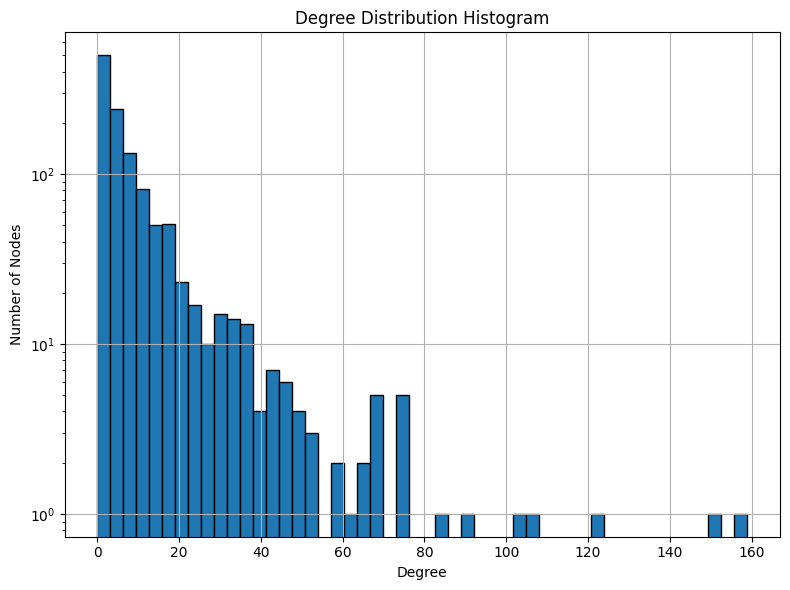

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist([d for _, d in brain_related_degree], bins=50, edgecolor='black')
plt.title("Degree Distribution Histogram")
plt.xlabel("Degree")
plt.ylabel("Number of Nodes")
plt.yscale('log')
# plt.xscale('log')
plt.grid(True)
plt.tight_layout()
plt.savefig("degree_distr_brain.png", dpi=300)
plt.show()

The degree distribution after the subgraphing is still preserved in the network, which highlights the smallworldness of the network is preserved over time.

### Clustering Coefficient

Then to have comparative results we calculated the same clustering coefficient for the Brain Network subgraph, and also the calculation of the top 10 nodes with the largest clustering_coefficient.

In [ ]:
brain_related_clustering_coefficient = nx.clustering(brain_related_G)
print("Clustering Coefficient: ", brain_related_clustering_coefficient)

Clustering Coefficient:  {55297: 0, 10242: 0, 6147: 0.3566666666666667, 2052: 0, 10243: 0.26666666666666666, 4099: 0.26666666666666666, 2056: 0, 55304: 0, 8202: 0.31339031339031337, 8204: 0.2727272727272727, 2064: 0.14666666666666667, 10257: 0, 2066: 0.19696969696969696, 100048912: 0, 18: 0, 143379: 0, 8216: 0.027777777777777776, 4122: 0, 90139: 0, 4124: 0, 29: 0, 54551: 0, 4128: 0.3055555555555556, 4129: 0.3055555555555556, 10274: 0, 36: 0.6666666666666666, 40: 0, 4137: 0.1931216931216931, 10280: 0, 4139: 0, 43: 0.3333333333333333, 8242: 0.16666666666666666, 2099: 0.10026138909634055, 2100: 0.22807017543859648, 10295: 0, 6202: 0.3689516129032258, 2107: 0, 120892: 0.1568627450980392, 280636: 0, 4160: 0, 4162: 0.3333333333333333, 4163: 0.10476190476190476, 55366: 0.007352941176470588, 2120: 0, 2131: 0, 692312: 0, 90: 0.1, 114781: 0, 84062: 0, 4192: 0, 8289: 0.19696969696969696, 4194: 0.26666666666666666, 114786: 0, 100: 0.07142857142857142, 114784: 0, 143458: 0, 8295: 0.4285714285714285

In [ ]:
# Find the top 10 nodes with the largest clustering_coefficient
top_10_brain_related_clustering_coefficient_nodes = sorted(brain_related_clustering_coefficient, key=brain_related_clustering_coefficient.get, reverse=True)[:10]

print("Top 10 nodes by Clustering Coefficient:")
for node in top_10_brain_related_clustering_coefficient_nodes:
    node_info = brain_related_G.nodes[node]
    print(f"Node ID: {node}, Clustering Coefficient: {brain_related_clustering_coefficient[node]:.4f}, Symbol: {node_info.get('symbol', 'N/A')}, Name: {node_info.get('name', 'N/A')}")

Top 10 nodes by Clustering Coefficient:
Node ID: 6277, Clustering Coefficient: 1.0000, Symbol: S100A6, Name: S100 calcium binding protein A6
Node ID: 3697, Clustering Coefficient: 1.0000, Symbol: ITIH1, Name: inter-alpha-trypsin inhibitor heavy chain 1
Node ID: 2222, Clustering Coefficient: 1.0000, Symbol: FDFT1, Name: farnesyl-diphosphate farnesyltransferase 1
Node ID: 4352, Clustering Coefficient: 1.0000, Symbol: MPL, Name: MPL proto-oncogene, thrombopoietin receptor
Node ID: 6414, Clustering Coefficient: 1.0000, Symbol: SELENOP, Name: selenoprotein P
Node ID: 283, Clustering Coefficient: 1.0000, Symbol: ANG, Name: angiogenin
Node ID: 8493, Clustering Coefficient: 1.0000, Symbol: PPM1D, Name: protein phosphatase, Mg2+/Mn2+ dependent 1D
Node ID: 389421, Clustering Coefficient: 1.0000, Symbol: LIN28B, Name: lin-28 RNA binding posttranscriptional regulator B
Node ID: 412, Clustering Coefficient: 1.0000, Symbol: STS, Name: steroid sulfatase
Node ID: 29091, Clustering Coefficient: 1.0000,